In [1]:
%config Completer.use_jedi = False
import sys, os
sys.path.append('../pyecog2')
sys.path.append('../')
from ProjectClass import Project,FileBuffer,MainModel
from classifier import GaussianClassifier, ProjectClassifier
# from pyecog2.main import MainModel
import json
import feature_extractor 
import importlib
importlib.reload(feature_extractor)
FeatureExtractor = feature_extractor.FeatureExtractor

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import spectrotools as spec
importlib.reload(spec)
from numba import jit, njit
import timeit

from scipy import stats
import json


In [2]:
main_model = MainModel()
project=Project(main_model=main_model)
project.load_from_json('/media/mfpleite/ExtSSD/ML_pyecog2/ClassifierCVProject.pyecog')
fe = FeatureExtractor()

ProjectClass set_current_animal start
ProjectClass set_current_animal ran in 0.00018281699999533885 seconds
ProjectClass set_current_animal start
ProjectClass set_current_animal ran in 0.0001310349999812388 seconds
looking for 120
ProjectClass set_current_animal start
ProjectClass set_current_animal ran in 0.0035672770000019227 seconds
current animal: 120


In [3]:
all_labels = project.get_all_labels()
print(all_labels)

{'seizure', 'seizure(ELE)', 'repetitive 4IEDs', 'Theta rhytm', 'Grooming'}


In [4]:
labels4report = {'seizure'}

In [5]:
classifier = ProjectClassifier(project)

loading /media/mfpleite/ExtSSD/ML_pyecog2/ClassifierCVProject.pyecog_classifier
Could not load imported classifier
Could not load feature extractor


## Event plotting
### plot over different periods
### do stats over animal groups

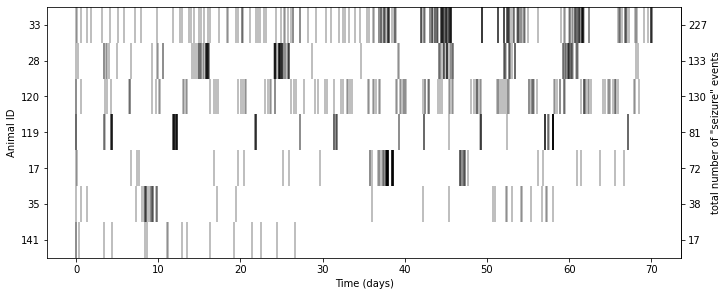

In [6]:
annotation_label2plot = 'seizure'
units = 'days'
units_size = 24*3600
start_point = [min([annotation.getStart() for annotation in animal.annotations.get_all_with_label(annotation_label2plot)])
              for animal in project.animal_list]
color = np.array(project.animal_list[0].annotations.label_color_dict[annotation_label2plot])/255

plot_data = []
for i,animal in enumerate(project.animal_list):
    starts,durations = zip(*[
                        ((annotation.getStart()-start_point[i])/units_size,
                         (annotation.getEnd()-annotation.getStart())/units_size)
                        for annotation in animal.annotations.get_all_with_label(annotation_label2plot)
                        ])
    plot_data.append([animal.id,starts,durations])

# sort by decreasing number of events
plot_data.sort(key= lambda x: len(x[1]), reverse=True)

fig,ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(10)
for i, data in enumerate(plot_data):
    ax.vlines(data[1], i-0.5, i+0.5,alpha = 0.25,color = 0*color,linewidth=2)
    

ax.set_ylim([len(plot_data)-.5,-.5])
ax.set_yticks(range(len(plot_data)));
ax.set_yticklabels(next(zip(*plot_data))); # grab animal id
ax.set_ylabel('Animal ID')
ax.set_xlabel(f'Time ({units})')
secax = ax.secondary_yaxis('right')
secax.set_ylabel(f'total number of "{annotation_label2plot}" events')
secax.set_yticks(range(len(plot_data)));
secax.set_yticklabels([str(len(d[1])) for d in plot_data]);

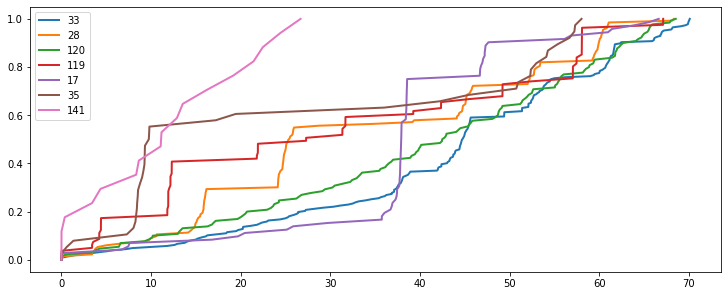

In [7]:
fig,ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(10)


for i, data in enumerate(plot_data):
    xdata = np.hstack((0,data[1])) # prepend start of experiment
    xdata.sort()
    ydata = np.linspace(0,1, len(xdata))
    ax.plot(xdata,ydata,linewidth=2,label=data[0])
    
ax.legend()


## Comparing different groups and periods

In [46]:
period_names = ['Baseline','Post']
groups = ['A','B']

period_date_ranges = {period_names[0]:(['2019-08-21 00:00:00','2019-08-22 00:00:00','2019-08-21 00:00:00','2019-09-21 00:00:00',
                          '2019-08-21 00:00:00','2019-08-21 00:00:00','2019-09-21 00:00:00'], # baseline start
                     ['2019-09-11 00:00:00','2019-09-11 00:00:00','2019-09-11 00:00:00','2019-10-10 00:00:00',
                          '2019-09-12 00:00:00','2019-09-12 00:00:00','2019-09-26 00:00:00']), # end of baseline)
                      period_names[1]:(['2019-09-11 00:00:00','2019-09-11 00:00:00','2019-09-11 00:00:00','2019-10-10 00:00:00',
                          '2019-09-12 00:00:00','2019-09-12 00:00:00','2019-09-26 00:00:00'], # injection day
                     ['2020-09-11 00:00:00','2020-09-11 00:00:00','2020-09-11 00:00:00','2020-10-10 00:00:00',
                          '2020-09-12 00:00:00','2020-09-12 00:00:00','2020-09-26 00:00:00']) # end of experime
                     }

animal_groups = ['A','B','A','B','B','A','A'] # animal groupd

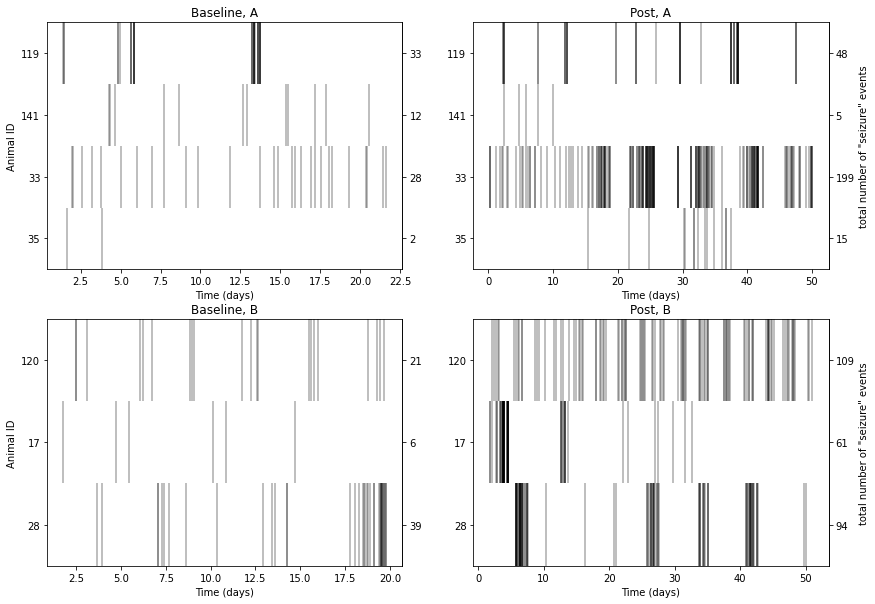

In [122]:
annotation_label2plot = 'seizure'
units = 'days'
units_size = 24*3600

nperiods = len(period_names)
ngroups  = len(groups)
plt.figure(figsize=(14,10))

date2timestamp = lambda s:datetime.fromisoformat(s).timestamp()

data_for_stats_nevents       = [[[] for i in period_names ] for  j in groups]
data_for_stats_totalduration = [[[] for i in period_names ] for  j in groups]

for i,period in enumerate(period_names):
    
    start_point = [date2timestamp(date) for date in period_date_ranges[period][0]]
    end_point   = [date2timestamp(date) for date in period_date_ranges[period][1]]
    
    for j,group in enumerate(groups):    
        ax = plt.subplot(ngroups,nperiods,j*nperiods+i+1)
        plt.title(f'{period}, {group}')
        
        plot_data = []
        for k,animal in enumerate(project.animal_list):
            
            if animal_groups[k] == group:
                starts,durations = zip(*[
                                    ((annotation.getStart()-start_point[k])/units_size,
                                     (annotation.getEnd()-annotation.getStart()))
                                    for annotation in animal.annotations.get_all_with_label(annotation_label2plot)
                                    if ((annotation.getStart()>start_point[k]) and (end_point[k]>annotation.getStart()))])
                plot_data.append([animal.id,starts,durations])
        
        data_for_stats_nevents[j][i]       = [len(data[1]) for data in plot_data]
        data_for_stats_totalduration[j][i] = [sum(data[2]) for data in plot_data]
        
        for k, data in enumerate(plot_data):
            ax.vlines(data[1], k-0.5, k+0.5,alpha = 0.25,color = 0*color,linewidth=2)
        ax.set_ylim([len(plot_data)-.5,-.5])
        ax.set_yticks(range(len(plot_data)));
        ax.set_yticklabels(next(zip(*plot_data))); # grab animal id
        if i == 0: # jsut for leftmost plots
            ax.set_ylabel('Animal ID')
            ax.set_yticklabels(next(zip(*plot_data))); # grab animal id
            
        ax.set_xlabel(f'Time ({units})')
        secax = ax.secondary_yaxis('right')
        if i == len(period_names)-1:
            secax.set_ylabel(f'total number of "{annotation_label2plot}" events')
        secax.set_yticks(range(len(plot_data)));
        secax.set_yticklabels([str(len(d[1])) for d in plot_data]);
        

In [123]:
log_data = list(map(np.log10,data_for_stats_nevents))

In [124]:
data_for_stats_nevents

[[[33, 12, 28, 2], [48, 5, 199, 15]], [[21, 6, 39], [109, 61, 94]]]

In [125]:
log_data

[array([[1.51851394, 1.07918125, 1.44715803, 0.30103   ],
        [1.68124124, 0.69897   , 2.29885308, 1.17609126]]),
 array([[1.32221929, 0.77815125, 1.59106461],
        [2.0374265 , 1.78532984, 1.97312785]])]

In [126]:
data_for_stats_totalduration

[[[2383.2600009441376,
   972.7800002098083,
   1476.3500006198883,
   133.9099998474121],
  [3802.7400000095367,
   477.85000014305115,
   9505.685160636902,
   1923.1799998283386]],
 [[1565.9899997711182, 731.1199998855591, 2697.0000007152557],
  [8723.812583208084, 5599.792798042297, 7237.664471387863]]]

## Now some stats

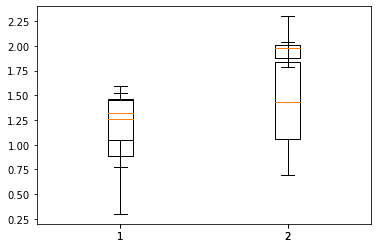

In [131]:
plt.boxplot(np.array(log_data[0]).T);
plt.boxplot(np.array(log_data[1]).T);

## Simulations of Poisson porcess statistics
Some example simulations to compare the distributions of the ratios of the means of poisson distributed variables versus the log difference of the means

In [8]:
N = 100000
v = np.zeros(N)
vb = np.zeros(N)

for i in range(N):
    rate = 5 + np.random.rand()*50 # simulate a population of mice with varying degrees of epilepsy severity
    v[i]  = np.random.poisson(rate,size=1)
    # there is usually a bias in the selection of animals that exibhit at least one seizure in the baseline period, 
    # interestingly this centers the ratio of means around 1...
    vb[i] = np.random.poisson(rate,size=1)+1 
    if not i%10000:
        print(f'{i}',end='\r')

print(f'\r{i}')

99999


Mean:1.0001187439203088, STD:0.33404896269957807


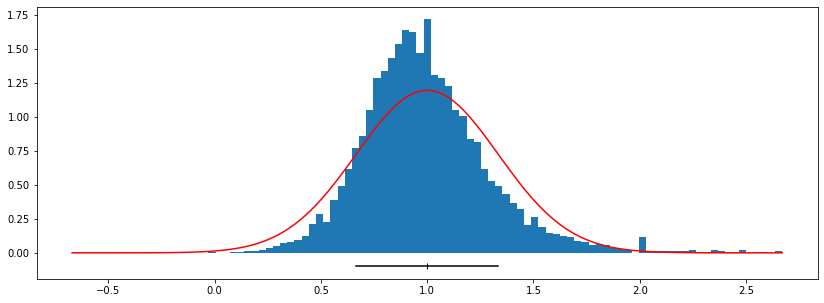

In [9]:
r=v/(vb)
mr = np.mean(r)
sdr= np.std(r)
bins =  np.linspace(mr-5*sdr,mr+5*sdr,100)
plt.figure(figsize=(14,5))
plt.hist(r,bins=bins ,density=True);
plt.plot(bins,1/np.sqrt(2*np.pi*sdr**2)*np.exp(-(bins-mr)**2/(2*sdr**2)),'r');
plt.plot(mr,-0.1,'k|');
plt.plot([mr-sdr,mr+sdr],[-0.1,-0.1],'k');
print(f'Mean:{mr}, STD:{sdr}')

Mean:0.00018149034924885659, STD:0.3022839030399138


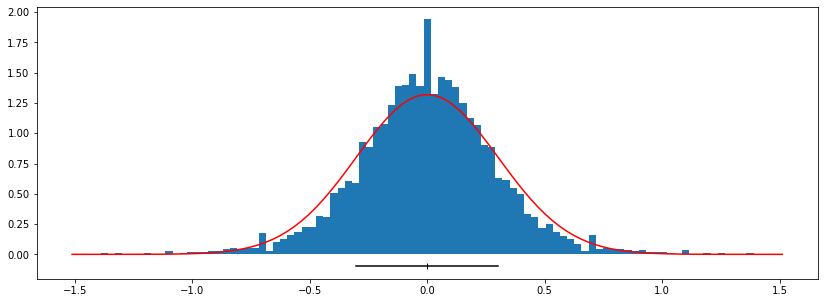

In [10]:
r  = np.log(v+1)-np.log(vb) # adding 1 to the readout period, to avoid underflows. The baseline is already biased to have at leas one seizure
mr = np.mean(r)
sdr= np.std(r)
bins =  np.linspace(mr-5*sdr,mr+5*sdr,100)
plt.figure(figsize=(14,5))
plt.hist(r,bins=bins ,density=True);
plt.plot(bins,1/np.sqrt(2*np.pi*sdr**2)*np.exp(-(bins-mr)**2/(2*sdr**2)),'r');
plt.plot(mr,-0.1,'k|');
plt.plot([mr-sdr,mr+sdr],[-0.1,-0.1],'k');
print(f'Mean:{mr}, STD:{sdr}')

Mean:-0.99115, STD:7.7473112547192775


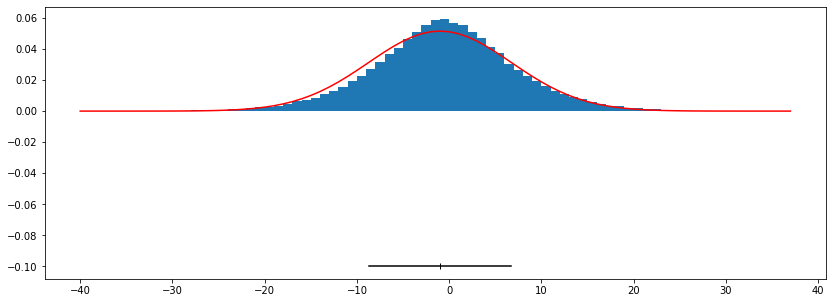

In [11]:
r  = v-vb 
mr = np.mean(r)
sdr= np.std(r)
bins =  np.arange(np.floor(mr-5*sdr),np.ceil(mr+5*sdr),1)
plt.figure(figsize=(14,5))
plt.hist(r,bins=bins ,density=True);
plt.plot(bins,1/np.sqrt(2*np.pi*sdr**2)*np.exp(-(bins-mr)**2/(2*sdr**2)),'r');
plt.plot(mr,-0.1,'k|');
plt.plot([mr-sdr,mr+sdr],[-0.1,-0.1],'k');
print(f'Mean:{mr}, STD:{sdr}')

### Conclusion:
The log difference of the means is closer to normally distributed when compared to the ratio of the means (notice the lack of simetry and the long tail to the right). This is of more relevance when the means are relatively low (<25) or, equivalently, when the variance of the data is larger than what predicted by the poisson distribution,e.g. seizures clustering in time.

## Notebook remote run tests

In [ ]:
from pyecog2.ProjectClass import Project, FileBuffer, MainModel
from pyecog2.classifier import intervals_overlap
import glob
import nbformat
import os
import shutil
from nbconvert.preprocessors import ExecutePreprocessor
from datetime import datetime

In [ ]:
import pyqtgraph as pg
import pyqtgraph.exporters
import numpy as np
from IPython.display import display, Image

def show_image(data):
    img = pg.image(data)
    file_name = "temp.png"
    exporter = pg.exporters.ImageExporter(img.imageItem).export(file_name)
    img.close()
    display(Image(filename=file_name))

data = np.array([[1,0],[2,3]])
show_image(data)

In [ ]:

main_model = MainModel()
project=Project(main_model=main_model)
project.load_from_json(project_file)